# Categories from numeric values

We often have a column with many numeric values and we want to group them to bins or buckets, such as age groups or value tiers. In Excel we can do it using: 

- Data Menu -> Data Analysis -> Histogram or Rank and Percentile
- _VLOOKUP_ (`=LOOKUP(A1,{0,7,14,31,90,180,360},{"0-6","7-13","14-30","31-89","90-179","180-359",">360"})`, for example), or 
- _IF_ (`=if(b2>30,"large",if(A1>20,"medium",if(A1>=10,"small",if(A1<10,"tiny",""))))`, for example)
- _INDEX_ (`=INDEX({"Small","Medium","Large"},LARGE(IF(A1>{0,11,21},{1,2,3}),1))`, for example)


[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aiola-lab/from-excel-to-pandas/blob/master/notebooks/02.08_group_values.ipynb)

## Cut Function

Since this is a common need, Pandas has built-in functions _cut_ and _qcut_ that make it more flexible and accurate.

In [1]:
import pandas as pd

## Real life example

### Loading Data

As usual, let's load a dataset to work on. We will use the dataset that is used before, "Bike Share". This is a data set about the demand of bike share service in Seoul. Please note that we need to modify the default encoding of _read_csv_ from 'UTF-8' to 'latin1'.

In [2]:
bike_share_data = (
    pd
    .read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', 
        encoding='latin1'
    )
)
bike_share_data

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


### Simple Data Visulizations

* Start with the table above
* Create Histograms for numeric columns
* Plot the histograms

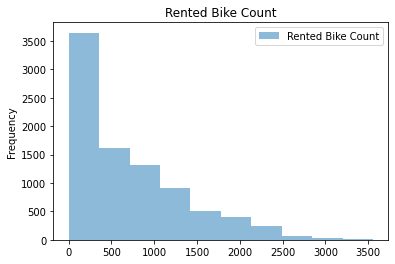

In [3]:
(
    bike_share_data
    [['Rented Bike Count']]
    .plot(
        kind='hist', 
        alpha=0.5, 
        title='Rented Bike Count'
    )
);

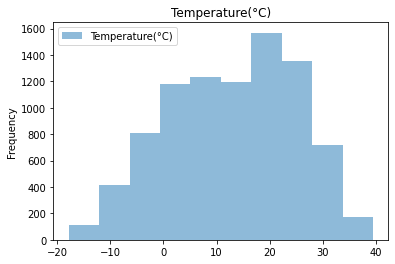

In [4]:
(
    bike_share_data
    [['Temperature(°C)']]
    .plot(
        kind='hist', 
        alpha=0.5, 
        title='Temperature(°C)'
    )
);

### Creating bins with _Cut_

* Start with the table above
* Focus on the temperature column
* Create 5 bins

In [5]:
(
    pd
    .cut(
        bike_share_data
        ['Temperature(°C)'], 
        5
    )  
)

0       (-6.36, 5.08]
1       (-6.36, 5.08]
2       (-6.36, 5.08]
3       (-6.36, 5.08]
4       (-6.36, 5.08]
            ...      
8755    (-6.36, 5.08]
8756    (-6.36, 5.08]
8757    (-6.36, 5.08]
8758    (-6.36, 5.08]
8759    (-6.36, 5.08]
Name: Temperature(°C), Length: 8760, dtype: category
Categories (5, interval[float64, right]): [(-17.857, -6.36] < (-6.36, 5.08] < (5.08, 16.52] < (16.52, 27.96] < (27.96, 39.4]]

We see the interval fo each of the bins:
`[(-17.857, -6.36] < (-6.36, 5.08] < (5.08, 16.52] < (16.52, 27.96] < (27.96, 39.4]]` that are in order and split to more or less equal sizes from temperature values perspective. Let's see how well they split the data:

* Split the temperature value into 5 bins
* Count the number of records in each bin
* Sort the values by the temperature range (the index of the series)


In [6]:
(
    pd
    .cut(
        bike_share_data
        ['Temperature(°C)'], 
        5
    )
    .value_counts()
    .sort_index()
)

(-17.857, -6.36]     529
(-6.36, 5.08]       1989
(5.08, 16.52]       2428
(16.52, 27.96]      2923
(27.96, 39.4]        891
Name: Temperature(°C), dtype: int64

First, we see that the bins are in order when we sort them, and not by alphabetic order. More importanty, we see that they are not equal in size of records, and not based on any other meaningful split.

### Setting the bins' limits

We can set the bins to be more meaningful by setting the limits explicitly. As experts in bicycles, we might know the temperature ranges that are suitable for different accessories and clothings. Let's fix the ranges based on this domain knowledge:

* Split the temperature value into 5 bins based on bicycle professional ranges
* Count the number of records in each bin
* Sort the values by the temperature range (the index of the series)



In [7]:
(
    pd
    .cut(
        bike_share_data
        ['Temperature(°C)'], 
        bins=[-18, 0, 8, 16, 24, 40]
    )
    .value_counts()
    .sort_index()
)


(-18, 0]    1454
(0, 8]      1731
(8, 16]     1651
(16, 24]    2148
(24, 40]    1776
Name: Temperature(°C), dtype: int64

### Adding meaningful labels

* Create a new column in the table for the temperature ranges
* Split the temperature value into 5 bins based on bicycle professional ranges
* Count the number of records in each bin
* Add human readable labels to the bins
* Sort the values by the temperature range (the index of the series)

In [8]:
bike_share_data['Temperature Range'] = (
    pd
    .cut(
        bike_share_data
        ['Temperature(°C)'], 
        bins=[-18, 0, 8, 16, 24, 40],
        labels=['Below Freezing', 'Freezing', 'Cold', 'Warm','Sizzling']
    )
    
)
(
    bike_share_data
    ['Temperature Range']
    .value_counts()
    .sort_index()
)


Below Freezing    1454
Freezing          1731
Cold              1651
Warm              2148
Sizzling          1776
Name: Temperature Range, dtype: int64

We see that the order is still the right order and not alphabetical, and the split is more balanced in the number of records.

### Boxplot for each bin

Now we can take every group of records and calculate and plot their box-plot showing the mean and the different quantiles of the different groups.

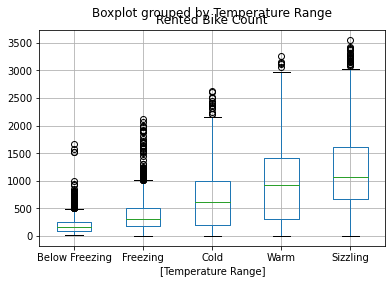

In [9]:
(
    bike_share_data
    [['Rented Bike Count','Temperature Range']]
    .boxplot(by='Temperature Range')
);

## What is wrong with Historgram

As much as historgrams are popular and simple to plot, they have many limitation:
- It depends (too much) on the number of bins.
- It depends (too much) on variable’s maximum and minimum.
- It doesn’t allow to detect relevant values.
- It doesn’t allow to discern continuous from discrete variables.
- It makes it hard to compare distributions.

We will use a couple of other plot option to see the data distributions more accurately.



### Kernel Density Estimator (KDE)

This method is calculating and plotting the estimation of the data distribution, and it is part of the Pandas built-in functions:

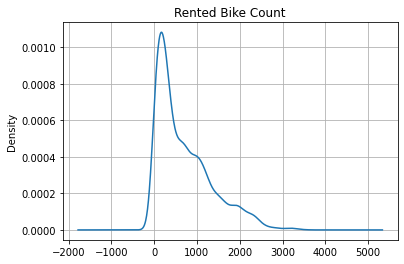

In [10]:
(
    bike_share_data
    ['Rented Bike Count']
    .plot
    .kde(
        title='Rented Bike Count',
        grid=True
    )
);

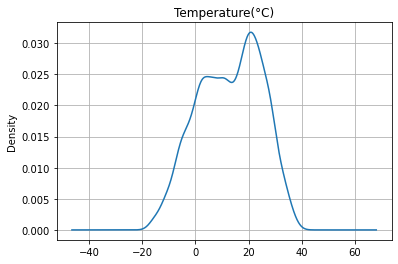

In [11]:
(
    bike_share_data
    ['Temperature(°C)']
    .plot
    .kde(
        title='Temperature(°C)', 
        grid=True
    )
);

### Cumulative Distribution Function (CDF)

The second option is using counts of the different percentiles of the data and using a cumulative plot makes it easy to find the value of each percentile and calculate the percentage of data points between every given percentiles.

In [13]:
%pip install statsmodels

     |████████████████████████████████| 9.9 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 71.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt


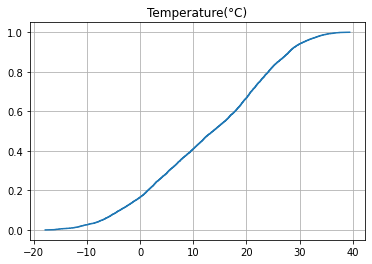

In [15]:
ecdf = ECDF(bike_share_data['Temperature(°C)'])
plt.plot(ecdf.x, ecdf.y)
plt.grid(True)
plt.title('Temperature(°C)'); 

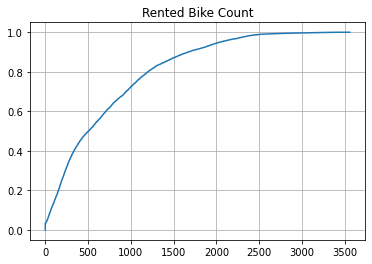

In [16]:
ecdf = ECDF(bike_share_data['Rented Bike Count'])
plt.plot(ecdf.x, ecdf.y)
plt.grid(True)
plt.title('Rented Bike Count'); 

## Group by Quantiles using _qcut_

When using a target score such as grades or number of rentals, it makes sense to use the split using the Quantiles of the scores. 

In [17]:
bike_share_data['Usage Level'] = (
    pd
    .qcut(
        bike_share_data['Rented Bike Count'], 
        q=4,
        labels=['Low', 'Medium', 'High', 'Very High']
    )
)
(
    bike_share_data
    ['Usage Level']
    .value_counts()
    .sort_index()
)

Low          2194
Medium       2186
High         2190
Very High    2190
Name: Usage Level, dtype: int64

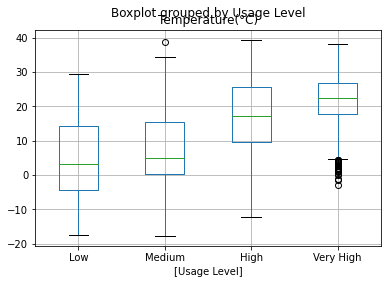

In [18]:
(
    bike_share_data
    [['Temperature(°C)','Usage Level']]
    .boxplot(by='Usage Level')
);

### Heat map with the new value group

Now that we have the new value categories and we can create heat map to see the hours of the day that are the peak hours that can be used with higher price tiers.

In [19]:
import seaborn as sns

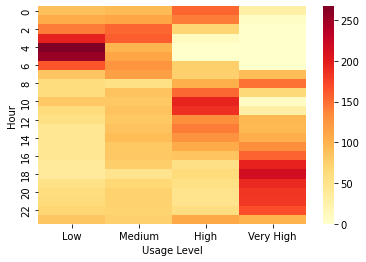

In [20]:
sns.heatmap(
    bike_share_data
    [['Usage Level','Hour','Date']]
    .pivot_table(
        index='Hour', 
        columns='Usage Level',
        aggfunc='count'
    )
    .droplevel(0, axis='columns'),
    cmap="YlOrRd"
);